# ObsID : 0945070133, SRCNUM : 10, Instru : EPN

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob

from astropy.io import fits
from astropy.stats import poisson_conf_interval

import stingray as st
from stingray import Lightcurve, AveragedPowerspectrum
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
from stingray.pulse.search import epoch_folding_search, z_n_search
from stingray.gti import create_gti_mask
from stingray.pulse.search import search_best_peaks
from stingray.stats import fold_detection_level, z2_n_detection_level

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plt.rcParams['figure.figsize'] = [10,5]

## Light curve

In [4]:
def periodicity(file, gtis, max_gti):
    hdul = fits.open(file)
    print()
    print(color.BOLD +file+ color.END)
    hdul.info()
    
    rate_data = hdul[1].columns
    print()
    print(rate_data)
        
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    error = hdul[1].data.field('ERROR')
    backrate = hdul[1].data.field('BACKV')
    
    lcs = []
    backlcs = []
    lcs.append(Lightcurve(time, rate, error, gti=gtis, input_counts=False))
    backlcs.append(Lightcurve(time, backrate, error, gti=gtis, input_counts=False))
    
    for i in range(len(lcs)):
        plt.xlabel('Time (s)')
        plt.ylabel('Countrate (/s)')
        plt.plot(lcs[i].time, lcs[i].countrate, color='steelblue', lw=1, ds='steps-mid', label='Source corr')
        plt.plot(backlcs[i].time, backlcs[i].countrate, color='firebrick',lw=1, ls='--', ds='steps-mid', label='Background')
        plt.title(f'{file}')
        plt.legend(loc='upper right')
        plt.grid()
        for j in range(len(lcs[i].gti)-1):
            plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
        plt.show()

    avg_ps = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
    
    def linear_fit(log_freq, slope, intercept):
        return slope * log_freq + intercept

    valid = (avg_ps.freq > 0) & (avg_ps.power > 0)
    log_freq = np.log10(avg_ps.freq[valid])
    log_power = np.log10(avg_ps.power[valid])

    params, _ = curve_fit(linear_fit, log_freq, log_power)
    slope, intercept = params
    
    # Ligne ajustée
    fitted_line = 10**(slope * log_freq + intercept)
    
    plt.plot(avg_ps.freq, avg_ps.power, lw=1, color='steelblue', label="Averaged PSD")
    plt.loglog(10**log_freq, fitted_line, color='firebrick', linestyle='--', lw=1, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (/rms)")
    plt.title(f'{file}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [5]:
def gtis(file):
    hdul = fits.open(file)
    gtis = []
    max_gti = 0
    for i in hdul[2].data:
        gtis.append([i[0],i[1]])
        if i[1] - i[0] > max_gti:
            max_gti = i[1] - i[0]
    print("max gti :", max_gti)
    return gtis, max_gti

### Time bin size = 10s

max gti : 8750.0

ObsID0945070133_SRCNUM10_EPN_t10_lccorr.lc
Filename: ObsID0945070133_SRCNUM10_EPN_t10_lccorr.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  RATE          1 BinTableHDU     84   875R x 6C   [D, E, E, E, E, E]   
  2  SRC_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  3  BKG_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  4  REG00105      1 BinTableHDU     24   1R x 5C   [16A, E, E, E, B]   

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count/s'
    name = 'ERROR'; format = 'E'; unit = 'count/s'
    name = 'FRACEXP'; format = 'E'; unit = 'fraction'
    name = 'BACKV'; format = 'E'; unit = 'count/s'
    name = 'BACKE'; format = 'E'; unit = 'count/s'
)


C:\Users\acer\anaconda3\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(


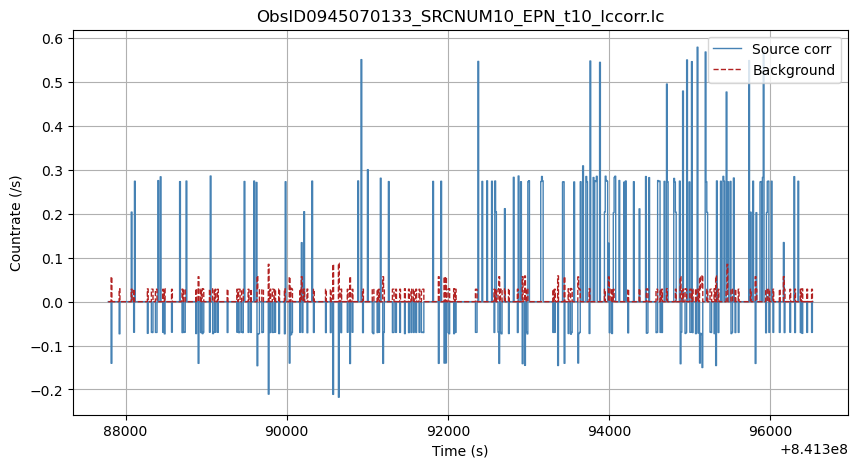

1it [00:00, 1003.66it/s]


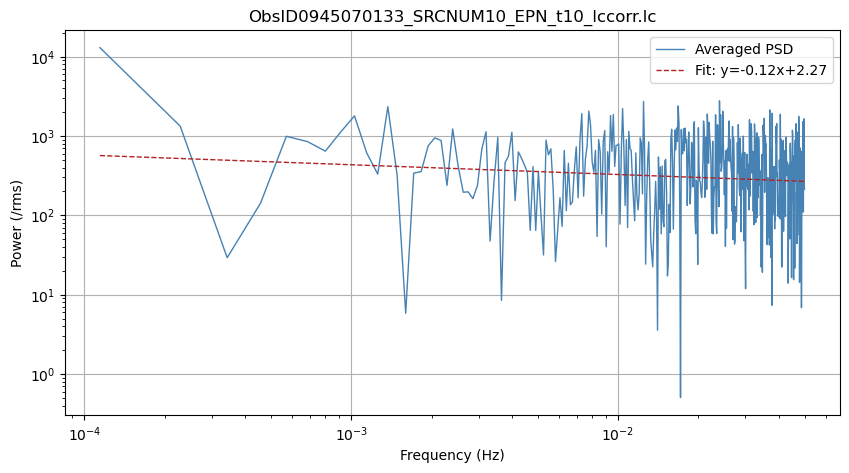

In [7]:
lc_fname10 = glob.glob('ObsID*_SRCNUM*_E*_t10_lccorr.lc')
gtis10, max_gti10 = gtis(lc_fname10[0])
periodicity(lc_fname10[0], gtis10, max_gti10)

### Time bin size = 50s

max gti : 8750.0

ObsID0945070133_SRCNUM10_EPN_t50_lccorr.lc
Filename: ObsID0945070133_SRCNUM10_EPN_t50_lccorr.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  RATE          1 BinTableHDU     84   175R x 6C   [D, E, E, E, E, E]   
  2  SRC_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  3  BKG_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  4  REG00105      1 BinTableHDU     24   1R x 5C   [16A, E, E, E, B]   

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count/s'
    name = 'ERROR'; format = 'E'; unit = 'count/s'
    name = 'FRACEXP'; format = 'E'; unit = 'fraction'
    name = 'BACKV'; format = 'E'; unit = 'count/s'
    name = 'BACKE'; format = 'E'; unit = 'count/s'
)


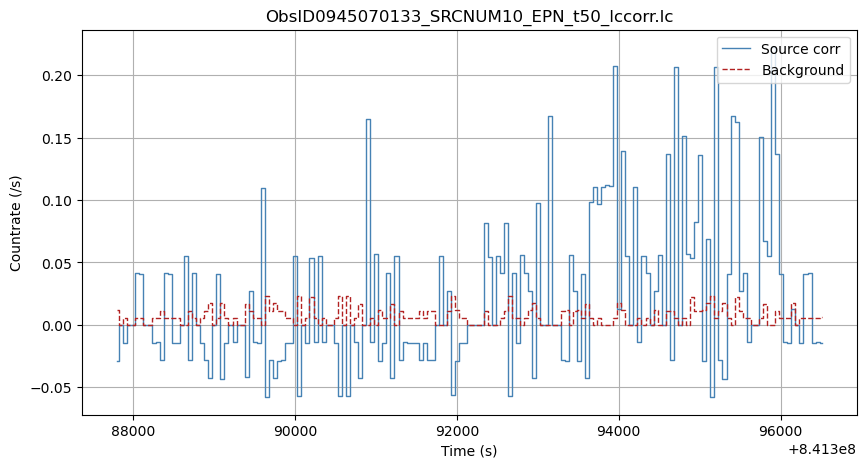

1it [00:00, 728.30it/s]


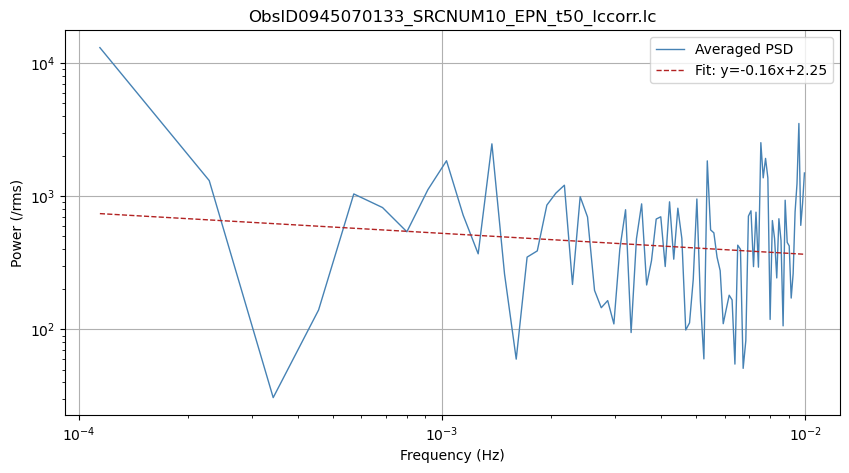

In [9]:
lc_fname50 = glob.glob('ObsID*_SRCNUM*_E*_t50_lccorr.lc')
gtis50, max_gti50 = gtis(lc_fname50[0])
periodicity(lc_fname50[0], gtis50, max_gti50)

### Time bin size = 200s

max gti : 8800.0

ObsID0945070133_SRCNUM10_EPN_t200_lccorr.lc
Filename: ObsID0945070133_SRCNUM10_EPN_t200_lccorr.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  RATE          1 BinTableHDU     84   44R x 6C   [D, E, E, E, E, E]   
  2  SRC_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  3  BKG_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  4  REG00105      1 BinTableHDU     24   1R x 5C   [16A, E, E, E, B]   

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count/s'
    name = 'ERROR'; format = 'E'; unit = 'count/s'
    name = 'FRACEXP'; format = 'E'; unit = 'fraction'
    name = 'BACKV'; format = 'E'; unit = 'count/s'
    name = 'BACKE'; format = 'E'; unit = 'count/s'
)


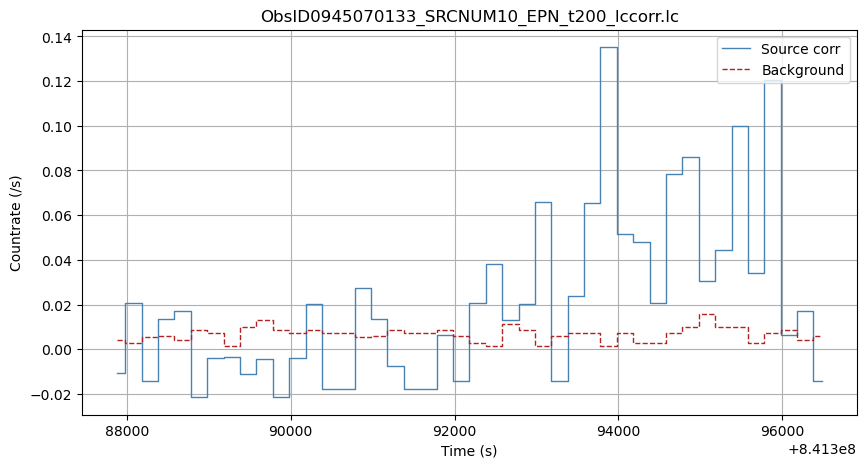

1it [00:00, 435.46it/s]


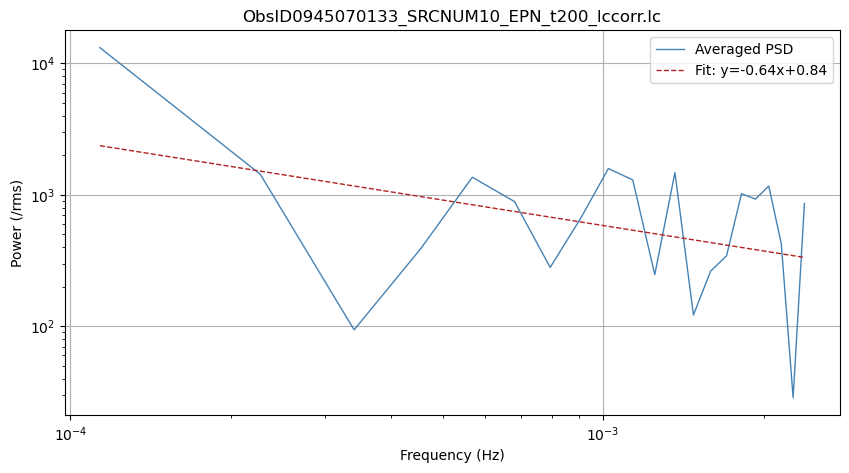

In [11]:
lc_fname200 = glob.glob('ObsID*_SRCNUM*_E*_t200_lccorr.lc')
gtis200, max_gti200 = gtis(lc_fname200[0])
periodicity(lc_fname200[0], gtis200, max_gti200)

### Time bin size = 500s

max gti : 9000.0

ObsID0945070133_SRCNUM10_EPN_t500_lccorr.lc
Filename: ObsID0945070133_SRCNUM10_EPN_t500_lccorr.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  RATE          1 BinTableHDU     84   18R x 6C   [D, E, E, E, E, E]   
  2  SRC_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  3  BKG_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  4  REG00105      1 BinTableHDU     24   1R x 5C   [16A, E, E, E, B]   

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count/s'
    name = 'ERROR'; format = 'E'; unit = 'count/s'
    name = 'FRACEXP'; format = 'E'; unit = 'fraction'
    name = 'BACKV'; format = 'E'; unit = 'count/s'
    name = 'BACKE'; format = 'E'; unit = 'count/s'
)


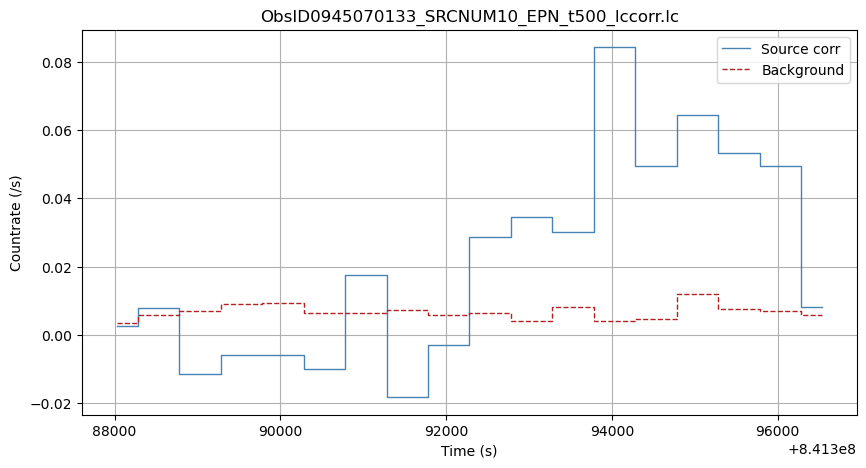

1it [00:00, ?it/s]


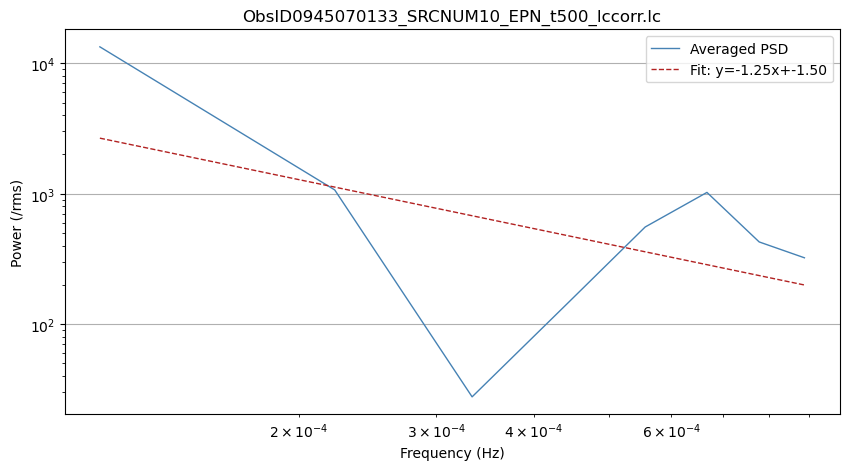

In [13]:
lc_fname500 = glob.glob('ObsID*_SRCNUM*_E*_t500_lccorr.lc')
gtis500, max_gti500 = gtis(lc_fname500[0])
periodicity(lc_fname500[0], gtis500, max_gti500)

## Event list

In [15]:
evt_names = glob.glob('*source_events.fits')

source_events = st.EventList.read(evt_names[0],fmt_='hea',skip_checks=True)
source_events.gti = gtis10
gti_mask = create_gti_mask(source_events.time,gtis10)
clean_times = source_events.time[gti_mask]
clean_events = st.EventList(clean_times, pi=source_events.pi[gti_mask])
clean_events.filter_energy_range([200,12000],inplace=True,use_pi=True)

C:\Users\acer\anaconda3\Lib\site-packages\stingray\base.py:1226: UserWarning: The time array is not sorted. Sorting it now.
  warnings.warn("The time array is not sorted. Sorting it now.")


In [16]:
obs_length = max(source_events.time) - min(source_events.time)
print("obs_length :", obs_length)
print()
df_min = 1/obs_length
oversampling=15
df = df_min / oversampling
frequencies = np.arange(2*df_min, 5, df)
print("frequencies :", frequencies)

obs_length : 8333.955476760864

frequencies : [2.39982084e-04 2.47981486e-04 2.55980889e-04 ... 4.99997872e+00
 4.99998671e+00 4.99999471e+00]


In [17]:
freq, efstat = epoch_folding_search(clean_events.time, frequencies, nbin=32, gti=gtis)
freq, zstat = z_n_search(clean_events.time, frequencies, nbin=32, nharm=1, gti=gtis)

In [18]:
ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(32, epsilon=0.001, ntrial=len(freq))

In [19]:
cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

print(len(cand_freqs_ef))
print(len(cand_freqs_z))

for i in range(len(cand_freqs_ef)):
    print("cand_freqs_ef :", cand_freqs_ef[i], "cand_stat_ef :", cand_stat_ef[i])

print()
for i in range(len(cand_freqs_z)):
    print("cand_freqs_z :", cand_freqs_z[i], "cand_stat_z :", cand_stat_z[i])

1
0
cand_freqs_ef : 2.967258472757208 cand_stat_ef : 103.46666666666667



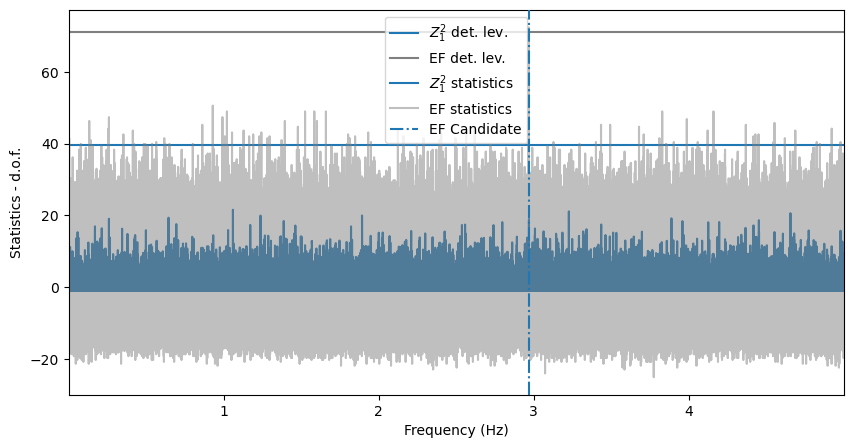

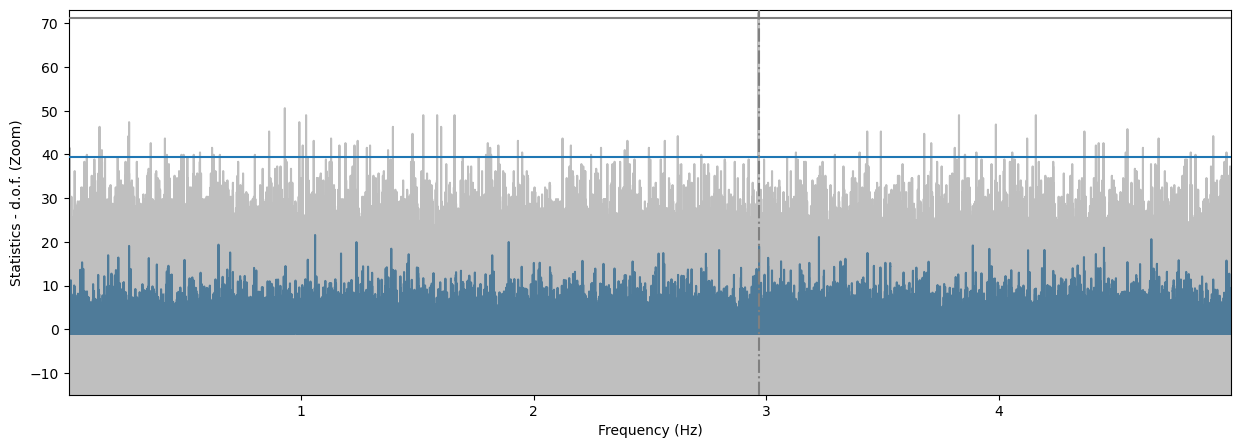

In [20]:
nharm=1
nbin=32
plt.figure()
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', zorder=10)
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray', zorder=10)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', color='gray', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, ef_detlev - nbin + 3])
_ = plt.xlim([frequencies[0], frequencies[-1]])

12979.019507616753


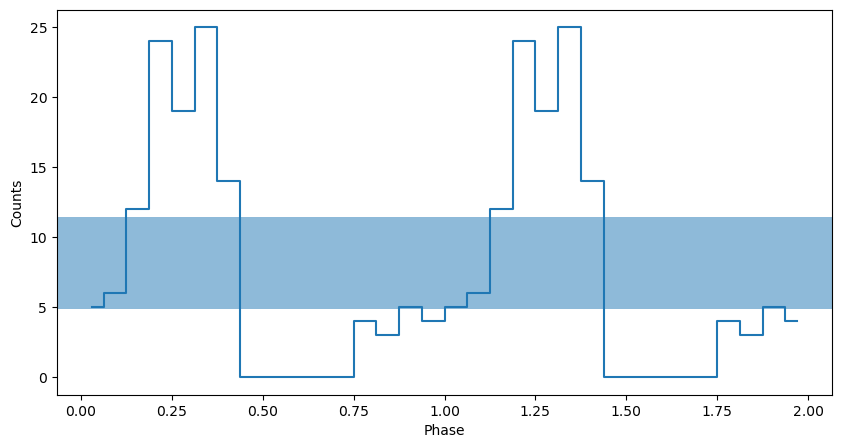

In [21]:
f0 = 7.704742252780719e-05
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_events.time, f0)
_ = plot_profile(ph,profile)

profile_err

ph_out = np.concatenate((ph,ph+1))
profile_out = np.concatenate((profile,profile))
prof_err_out = np.concatenate((profile_err,profile_err))

np.savetxt('ObsID0945070133_SRCNUM10_EPN_pulse_profile.csv',(ph_out, profile_out,prof_err_out),delimiter=',')

In [22]:
err_low, err_high = poisson_conf_interval(np.mean(profile), interval="frequentist-confidence", sigma=1)
print(np.mean(profile),err_low, err_high)

print()
err_low, err_high = poisson_conf_interval(np.mean(profile), interval="frequentist-confidence", sigma=3)
print(np.mean(profile),err_low, err_high)

7.5625 4.874290748365169 11.432448471802802

7.5625 1.8603076017678655 20.029703987928528
